## 이미지 불러오기

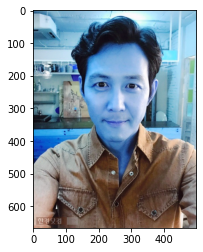

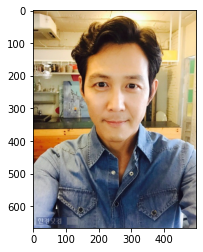

In [3]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import dlib

my_image_path = './img/test_img.png'
# OpenCV: 이미지를 불러오기
img_bgr = cv2.imread(my_image_path)    
plt.imshow(img_bgr)
plt.show()

# openCV(BGR) to RGB 변환 
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

### imread(path, flag)

#### flag 3가지 종류

cv2.IMREAD_COLOR : 이미지 파일을 Color로 읽어들입니다. 투명한 부분은 무시되며, Default값입니다.<br>
cv2.IMREAD_GRAYSCALE : 이미지를 Grayscale로 읽어 들입니다. 실제 이미지 처리시 중간단계로 많이 사용합니다.<br>
cv2.IMREAD_UNCHANGED : 이미지파일을 alpha channel까지 포함하여 읽어 들입니다.<br>


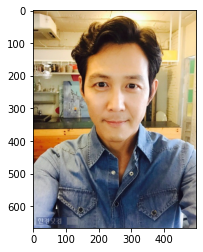

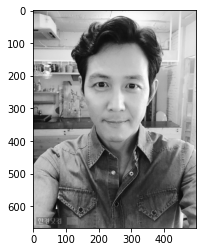

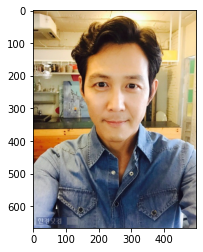

In [4]:
flg_img_bgr = cv2.imread(my_image_path, 1)    
flg_img_rgb = cv2.cvtColor(flg_img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(flg_img_rgb)
plt.show()

flg_img_bgr = cv2.imread(my_image_path, 0)    
flg_img_rgb = cv2.cvtColor(flg_img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(flg_img_rgb)
plt.show()

flg_img_bgr = cv2.imread(my_image_path, -1)    
flg_img_rgb = cv2.cvtColor(flg_img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(flg_img_rgb)
plt.show()

## Face detection

In [5]:
# detector를 선언합니다
detector_hog = dlib.get_frontal_face_detector()

# bounding box 추출
dlib_rects = detector_hog(img_rgb, 1)   # (image, num of image pyramid)
print(dlib_rects)

rectangles[[(142, 167) (365, 390)]]


rectangles[[(142, 167) (365, 390)]]
142 167 365 390


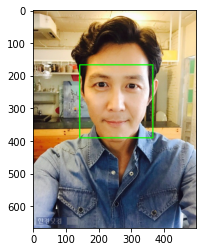

In [6]:
# 찾은 얼굴 영역 박스 리스트
# 여러 얼굴이 있을 수 있습니다. return -> list
print(dlib_rects)   

img_show = img_bgr.copy()
for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()
    print(l, t, r, b)

    # dlib.rectangles(img, start_point, end_point, line_color, line_width, line_type)    
    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

### Face landmark

Object keypoint estimation 알고리즘
 : Face landmark와 같이 객체 내부의 점을 찾는 기술. keypoint를 찾는 알고리즘은 크게 2가지

1) top-down : bounding box를 찾고 box 내부의 keypoint를 예측
2) bottom-up : 이미지 전체의 keypoint를 먼저 찾고 point 관계를 이용해 군집화 해서 box 생성

지금 방식은 top-down

68


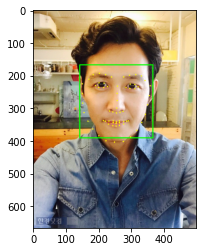

In [7]:
model_path = './models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)

list_landmarks = []

# 얼굴 영역 박스 마다 face landmark를 찾아냅니다
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    # face landmark 좌표를 저장해둡니다
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0]))

for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(img_show, point, 2, (0, 255, 255), -1)

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

## 스티커 적용

(255, 299)
(x,y) : (255,187)
(w,h) : (224,224)
(224, 224, 3)


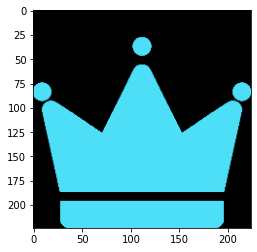

In [20]:
# 사진에 따라 위치가 변하기 떄문에
# 스티커의 크기는 detection rect에 의해 정함
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    # 코의 index : 30
    # landmark[30] = (x, y)
    print (landmark[30]) 
    x = landmark[30][0]
    y = landmark[30][1] - dlib_rect.height()//2
    w = h = dlib_rect.width()
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))

sticker_path = './img/king.png'
img_sticker = cv2.imread(sticker_path) # 스티커 이미지를 불러옵니다
img_sticker = cv2.resize(img_sticker, (w,h))
print (img_sticker.shape)

plt.imshow(img_sticker)
plt.show()

In [21]:
refined_x = x - w // 2
refined_y = y - h
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

# 계산결과 -값이 존재
# 사진을 벗어나는 영역 존재

(x,y) : (143,-37)


(x,y) : (143,0)


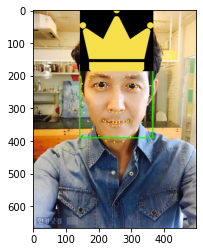

In [22]:
# 사진 영역을 벗어나는 sticker 이미지 편집
if refined_x < 0: 
    img_sticker = img_sticker[:, -refined_x:]
    refined_x = 0
if refined_y < 0:
    img_sticker = img_sticker[-refined_y:, :]
    refined_y = 0

print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

# img에서 sticker가 들어갈 지역 추출
x_start_refined = refined_y
x_finish_refined = refined_y+img_sticker.shape[0]
y_start_refined = refined_x
y_finish_refined = refined_x+img_sticker.shape[1]
sticker_area = img_show[x_start_refined:x_finish_refined, y_start_refined:y_finish_refined]

# sticker 이미지의 투명(값이 0)인 부분에 원본 이미지의 값을 채워 넣어줌
# np.where : 조건에 맞는 인덱스 찾기 및 값 변경
# np.where(condition, T, F)
# np.where(조건, 참일때 값, 거짓일떄 값)

edit_img_sticker = np.where(img_sticker==0,sticker_area,img_sticker).astype(np.uint8)
img_show[x_start_refined:x_finish_refined, refined_x:y_finish_refined] = edit_img_sticker

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

(x,y) : (143,0)


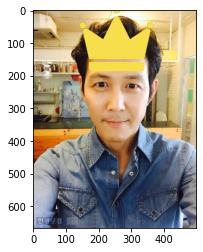

In [18]:
img_show = img_bgr.copy()

img_sticker = cv2.imread(sticker_path) # 스티커 이미지를 불러옵니다
img_sticker = cv2.resize(img_sticker, (w,h))

refined_x = x - w // 2
refined_y = y - h

# 사진 영역을 벗어나는 sticker 이미지 편집
if refined_x < 0: 
    img_sticker = img_sticker[:, -refined_x:]
    refined_x = 0
if refined_y < 0:
    img_sticker = img_sticker[-refined_y:, :]
    refined_y = 0

print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

# img에서 sticker가 들어갈 지역 추출
x_start_refined = refined_y
x_finish_refined = refined_y+img_sticker.shape[0]
y_start_refined = refined_x
y_finish_refined = refined_x+img_sticker.shape[1]
sticker_area = img_show[x_start_refined:x_finish_refined, y_start_refined:y_finish_refined]

# sticker 이미지의 투명(값이 0)인 부분에 원본 이미지의 값을 채워 넣어줌
# np.where : 조건에 맞는 인덱스 찾기 및 값 변경
# np.where(condition, T, F)
# np.where(조건, 참일때 값, 거짓일떄 값)

edit_img_sticker = np.where(img_sticker==0,sticker_area,img_sticker).astype(np.uint8)
img_show[x_start_refined:x_finish_refined, refined_x:y_finish_refined] = edit_img_sticker

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()


In [19]:
# list 영역에 list로 값 대입
a = [i for i in range(25)]
print(a)

b= [9, 9, 9]

a[1:4] = b
print(a)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
[0, 9, 9, 9, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]


### png 테스트

In [ ]:

sticker_path3 = './img/king.png'
img_sticker3 = cv2.imread(sticker_path3) # 스티커 이미지를 불러옵니다
#img_sticker1[:, :, -1] = 255
print(type(img_sticker3))
print(img_sticker3[0])
plt.imshow(img_sticker3)
plt.show()

sticker_path1 = './img/king.png'
img_sticker1 = cv2.imread(sticker_path1, cv2.IMREAD_UNCHANGED) # 스티커 이미지를 불러옵니다
#img_sticker1[:, :, -1] = 255
print (img_sticker1[0])
plt.imshow(img_sticker1[:, :, :-1])
plt.show()

sticker_path4 = './img/cat-whiskers.png'
img_sticker4 = cv2.imread(sticker_path4, cv2.IMREAD_COLOR) # 스티커 이미지를 불러옵니다
print (img_sticker4[0])
plt.imshow(img_sticker4)
plt.show()

sticker_path2 = './img/cat-whiskers.png'
img_sticker2 = cv2.imread(sticker_path2, cv2.IMREAD_UNCHANGED) # 스티커 이미지를 불러옵니다
img_sticker2[:, :, :-1] = 255 - img_sticker2[:, :, :-1]
print (img_sticker2[0])
plt.imshow(img_sticker2[:, :, :-1])
plt.show()

